In [612]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [613]:
df = pd.read_csv('graduation_dataset.csv')

### Dropper target for unsupervised clustering, kan brukes senere for validation kanskje

In [616]:
X = df.drop(columns=["Target"])
y = df["Target"]

In [617]:
X.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,6.886980,1.727848,9.899186,0.890823,2.531420,1.254521,12.322107,16.455244,7.317812,7.819168,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,5.298964,1.313793,4.331792,0.311897,3.963707,1.748447,9.026251,11.044800,3.997828,4.856692,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,18.000000,9.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,46.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


### Må gjøre kolonnene om til kategoriske for one hot encoding da de ble tolket som kontinuerlige..

In [619]:
categorical_cols = [
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (without evaluations)',
]

for col in categorical_cols:
    X[col] = X[col].astype('category')


### Scaling av datasettet

In [620]:
from sklearn.preprocessing import StandardScaler

#one hot encoding and scaling
X_encoded = pd.get_dummies(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [621]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)
X_scaled_df

,Age at enrollment,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP,Marital status_1,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_1,Application mode_2,Application mode_3,Application mode_4,Application mode_5,Application mode_6,Application mode_7,Application mode_8,Application mode_9,Application mode_10,Application mode_11,Application mode_12,Application mode_13,Application mode_14,Application mode_15,Application mode_16,Application mode_17,Application mode_18,Application order_0,Application order_1,Application order_2,Application order_3,Application order_4,Application order_5,Application order_6,Application order_9,Course_1,Course_2,Course_3,Course_4,Course_5,Course_6,Course_7,Course_8,Course_9,Course_10,Course_11,Course_12,Course_13,Course_14,Course_15,Course_16,Course_17,Daytime/evening attendance_0,Daytime/evening attendance_1,Previous qualification_1,Previous qualification_2,Previous qualification_3,Previous qualification_4,Previous qualification_5,Previous qualification_6,Previous qualification_7,Previous qualification_8,Previous qualification_9,Previous qualification_10,Previous qualification_11,Previous qualification_12,Previous qualification_13,Previous qualification_14,Previous qualification_15,Previous qualification_16,Previous qualification_17,Nacionality_1,Nacionality_2,Nacionality_3,Nacionality_4,Nacionality_5,Nacionality_6,Nacionality_7,Nacionality_8,Nacionality_9,Nacionality_10,Nacionality_11,Nacionality_12,Nacionality_13,Nacionality_14,Nacionality_15,Nacionality_16,Nacionality_17,Nacionality_18,Nacionality_19,Nacionality_20,Nacionality_21,Mother's qualification_1,Mother's qualification_2,Mother's qualification_3,Mother's qualification_4,Mother's qualification_5,Mother's qualification_6,Mother's qualification_7,Mother's qualification_8,Mother's qualification_9,Mother's qualification_10,Mother's qualification_11,Mother's qualification_12,Mother's qualification_13,Mother's qualification_14,Mother's qualification_15,Mother's qualification_16,Mother's qualification_17,Mother's qualification_18,Mother's qualification_19,Mother's qualification_20,Mother's qualification_21,Mother's qualification_22,Mother's qualification_23,Mother's qualification_24,Mother's qualification_25,Mother's qualification_26,Mother's qualification_27,Mother's qualification_28,Mother's qualification_29,Father's qualification_1,Father's qualification_2,Father's qualification_3,Father's qualification_4,Father's qualification_5,Father's qualification_6,Father's qualification_7,Father's qualification_8,Father's qualification_9,Father's qualification_10,Father's qualification_11,Father's qualification_12,Father's qualification_13,Father's qualification_14,Father's qualification_15,Father's qualification_16,Father's qualification_17,Father's qualification_18,Father's qualification_19,Father's qualification_20,Father's qualification_21,Father's qualification_22,Father's qualification_23,Father's qualification_24,Father's qualification_25,Father's qualification_26,Father's qualification_27,Father's qualification_28,Father's qualification_29,Father's qualification_30,Father's qualification_31,Father's qualification_32,Father's qualification_33,Father's qualification_34,Mother's occupation_1,Mother's occupation_2,Mother's occupation_3,Mother's occupation_4,Mother's occupation_5,Mother's occupation_6,Mother's occupation_7,Mother's occupation_8,Mother's occupation_9,Mother's occupation_10,Mother's occupation_11,Mother's occupation_12,Mother's occupation_13,Mother's occupation_14,Mother's occupation_15,Mother's occupation_16,Mother's occupation_17,Mother's occupation_18,Mother's occupation_19,Mother's occupation_20,Mother's occupation_21,Mother's occupation_22,Mother's occupation_23,Mother's occupation_24,Mother's occupation_25,Mother's occupation_26,Mother's occupation_27,Mother's occupation_28,Mother's occupation_29,Mother's occupation_30,Mother

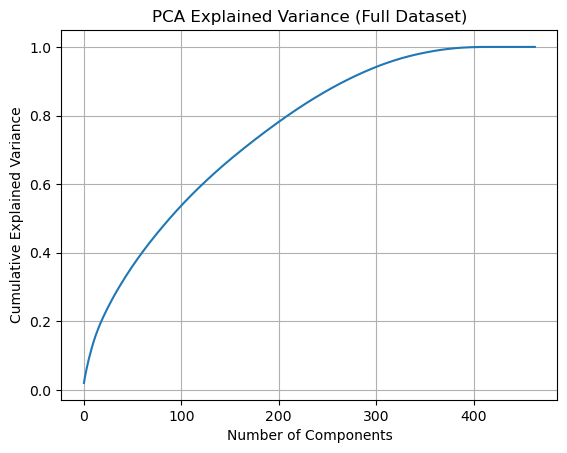

In [622]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_full = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance (Full Dataset)")
plt.grid(True)
plt.show()


## PCA

In [ ]:
from sklearn.decomposition import PCA
# 8, 18, 36 decent 45 tilslutt
randomstate = 42
num_k = 4

pca = PCA(n_components=150, random_state=randomstate)
X_pca = pca.fit_transform(X_scaled_df)
print("PCA components:", X_pca.shape[1])
print(f'Randiom state: {randomstate}')

PCA components: 150
Randiom state: 45


In [891]:
explained_variance = pca.explained_variance_ratio_.sum()
print(explained_variance)

0.661280635342339


## CLUSTERING

### K-means

In [892]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [893]:
K = range(2, 10)
inertia = []
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=randomstate)
    labels = km.fit_predict(X_pca)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))

### Elbow plot and silhouette plot

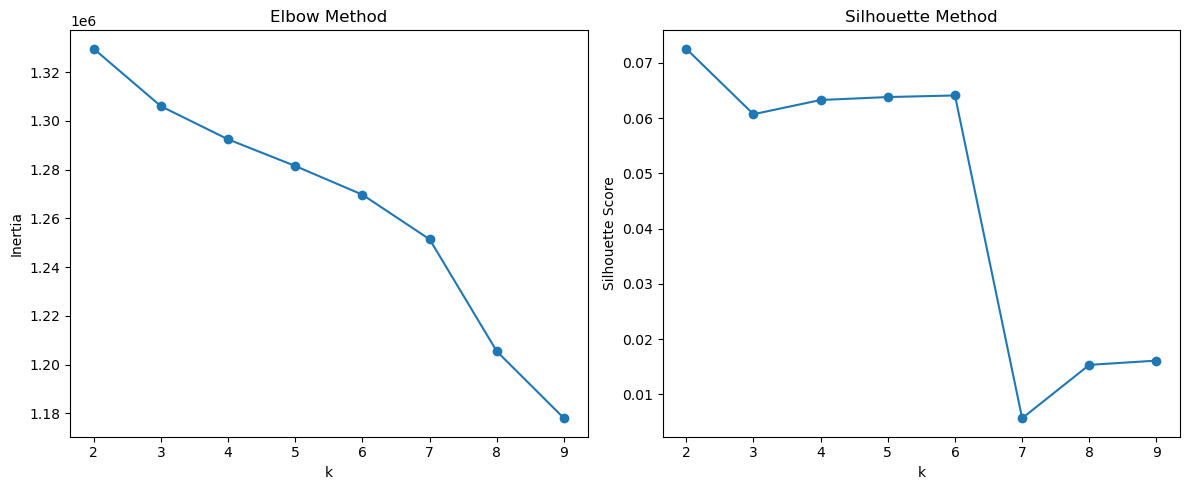

In [894]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(K, inertia, marker='o')
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow Method")

axes[1].plot(K, sil_scores, marker='o')
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Method")

plt.tight_layout()
plt.show()

### Choose K based on plots

In [895]:
k_values = [2, 3, 4, 6, 8, 10]

In [896]:
kmeans = KMeans(n_clusters=num_k, random_state=randomstate)
clusters = kmeans.fit_predict(X_pca)

In [897]:
print(f'Med k={num_k} og randomstate={randomstate}')
print("Final silhouette score:", silhouette_score(X_pca, clusters))
print("Davies-Bouldin score:", davies_bouldin_score(X_pca, clusters))

Med k=4 og randomstate=45
Final silhouette score: 0.06328696733615255
Davies-Bouldin score: 3.7186841661707897


### PCA2 for visualization

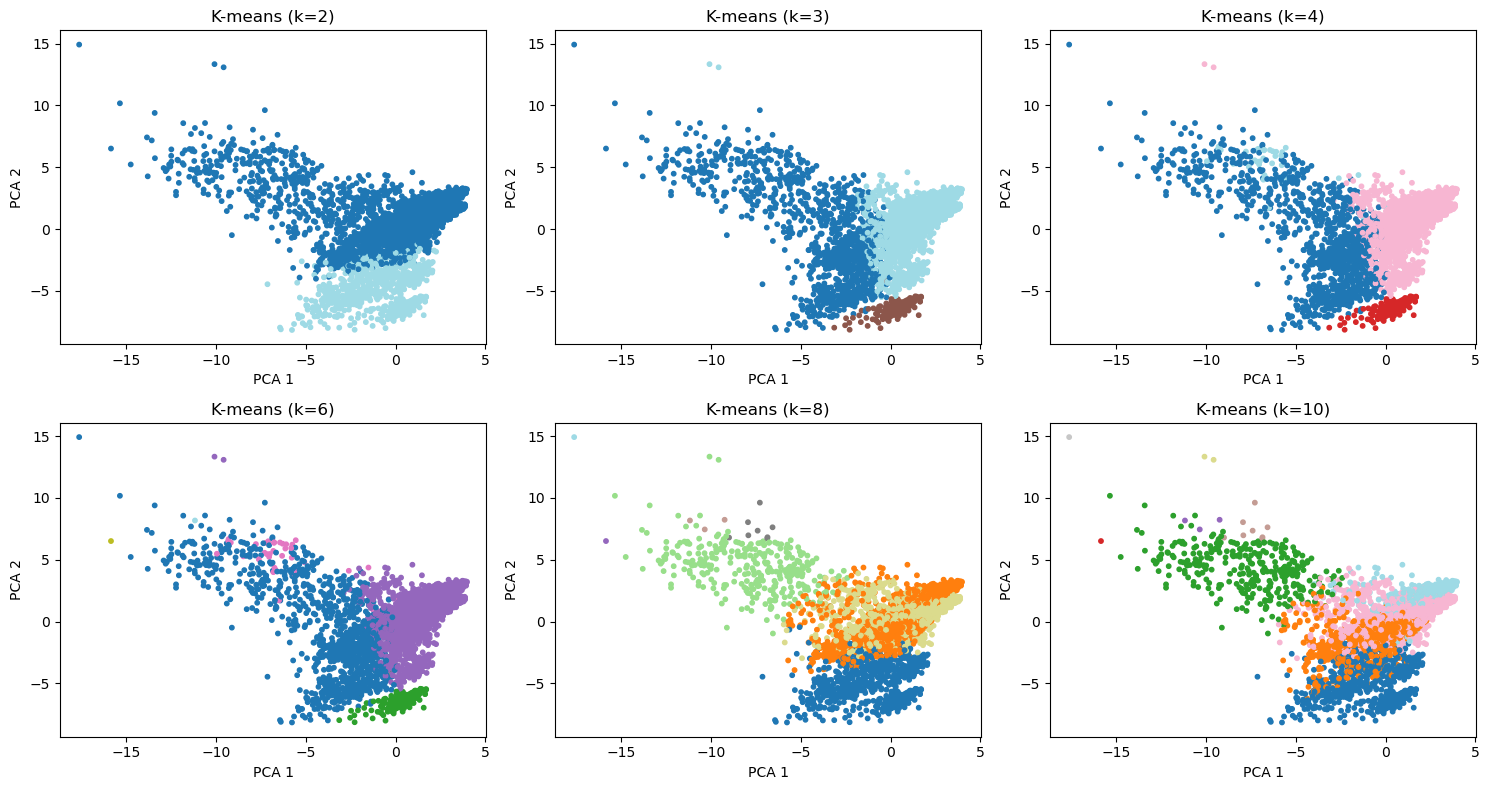

In [898]:
x1 = X_pca[:, 0]
x2 = X_pca[:, 1]

rows = 2
cols = (len(k_values) + 1) // 2
plt.figure(figsize=(15, 8))

for i, k in enumerate(k_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=randomstate)
    labels = kmeans.fit_predict(X_pca)

    plt.subplot(rows, cols, i)
    plt.scatter(x1, x2, c=labels, s=10, cmap='tab20')
    plt.title(f'K-means (k={k})')
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

## Andre algoritmer